In [2]:
import matplotlib.pyplot as plt
import numpy.random
import numpy as np
import seaborn
import sklearn as sk
import pandas as pd
import glob
import os
import scipy.io
import tensorflow as tf

%pylab inline

print('\nThe scikit-learn version is {}.'.format(sk.__version__))
print('The Numpy version is {}.'.format(np.__version__))
print('The TensorFlow version is {}.'.format(tf.__version__))

Populating the interactive namespace from numpy and matplotlib

The scikit-learn version is 0.18.1.
The Numpy version is 1.12.1.
The TensorFlow version is 1.0.1.


## Defining Functions and Figure Output Preferences

In [3]:
pylab.rcParams['figure.figsize'] = (8, 4)
pylab.rcParams['xtick.labelsize'] = 16
pylab.rcParams['ytick.labelsize'] = 16
pylab.rcParams['axes.labelsize'] = 15
pylab.rcParams['legend.fontsize'] = 15
pylab.rcParams['axes.titlesize'] = 17
pylab.rcParams['legend.frameon'] = True 
pylab.rcParams['figure.facecolor'] = 'white' 

def listOfFiles(path):
    itemAll=[]
    for item in os.listdir(path):
        if not item.startswith('.') and os.path.isfile(os.path.join(path, item)):
            itemAll.append(item)
    return itemAll
def leastSquareErr(Y,YHat):
    Err=0
    for x in xrange(len(Y)):
        Err+=((Y[x]-YHat[x]))**2
    return Err
def obtainRows(Val,M):
    List=[]
    for i in xrange(len(M)):
        if Val[0]==M[i,0] and Val[1]==M[i,1]:
            List.append(M[i,:])
    ret=np.array(List)
    ret.sort(axis=0)
    return ret
def normalizeData(X):
    return X/min(X)

## Importing Data/ Parsing Files

In [4]:
# Import Parameters
path='Data2/' #path to data folder
HMaster=10
TMaster=1

In [39]:
dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))] #Getting names of directories
try: del dataKAll
except: pass
try: del dataPAll
except: pass
VPAll=np.array([]);VKAll=np.array([])
for dirr in dirs:
    fileListAll=listOfFiles(path+dirr)
    for filer in fileListAll:
        ff=filer.split('.')[0] #get rit of .out
        PVK=ff.split('-')[1] # obtain file type from the file name
        
        if PVK=='PV' or PVK=='VK': #Check to see what file type it is
            data = np.loadtxt(path+dirr+'/'+filer, delimiter=' ')
            H=float(ff.split('H')[1].split('T')[0])*HMaster/100.+data[:,0]*0.
            T=float(ff.split('T')[1].split('-')[0])*TMaster/100+data[:,0]*0.
            
            if PVK=='PV': #file PV: col0 V; col1 P
                V=data[:,0]-min(data[:,0])
                VPAll=np.append(VPAll,data[:,0])
                P=data[:,1]
                dataAll=np.column_stack((H,T,V,P))
                try: dataPAll=np.vstack((dataPAll,dataAll))
                except: dataPAll=dataAll
                
            if PVK=='VK': #file VK: col0 K; col1 V
                V=data[:,1]-min(data[:,1])
                VKAll=np.append(VKAll,data[:,1])
                K=data[:,0]/(np.pi/50)
                dataAll=np.column_stack((H,T,V,K))
                try: dataKAll=np.vstack((dataKAll,dataAll))
                except: dataKAll=dataAll

#normalizing data
dataPAll[:,0]=normalizeData(dataPAll[:,0])
dataKAll[:,0]=normalizeData(dataKAll[:,0])

dataPAll[:,1]=normalizeData(dataPAll[:,1])
dataKAll[:,1]=normalizeData(dataKAll[:,1])

dataPAll[:,2]=dataPAll[:,2]/min(VPAll)
dataKAll[:,2]=dataKAll[:,2]/min(VKAll)

np.random.shuffle(dataKAll)
np.random.shuffle(dataPAll)

XK=dataKAll[:,:-1]
YK=dataKAll[:,-1]
XP=dataPAll[:,:-1]
YP=dataPAll[:,-1]

#export data into matlab matrix form
scipy.io.savemat('Matlab/MatlabData.mat', dict(dataKAll=dataKAll, dataPAll=dataPAll))
print 'VPALL:',min(VPAll)
print 'VKALL:',min(VKAll)

VPALL: 1256.66662598
VKALL: 1256.66662598


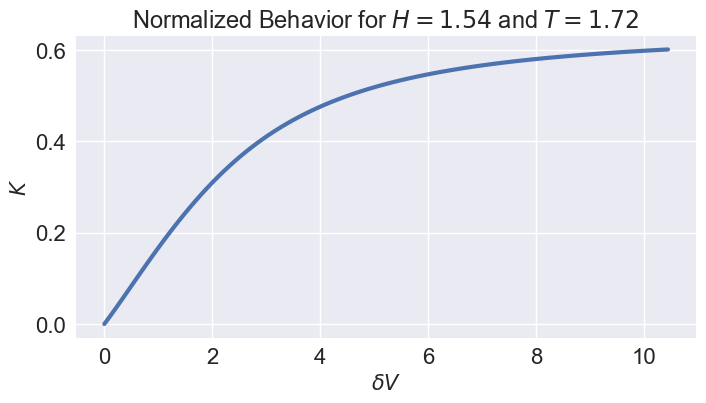

In [40]:
H=77./50.;T=86./50.
rawData = obtainRows([H,T],dataKAll)
V=rawData[:,2]
K=rawData[:,-1]

plt.title(r'Normalized Behavior for $H={}$ and $T={}$'.format(H,T))
plt.xlabel(r'$\delta V$')
plt.ylabel(r'$K$')
plt.plot(V,K,label='Data',lw=3)

## Neural Networks Learning Algorithm

### Using SciKit Learn

In [23]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
MLP=RandomForestRegressor(n_estimators=5000)
# MLP=MLPRegressor(hidden_layer_sizes=(2000, ), activation='logistic', solver='sgd', alpha=0.0001, batch_size='auto',
#      learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
#      shuffle=True, random_state=None, tol=0.0001, verbose=False, 
#      warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
#      validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
TrainL=int(len(YP)*100./100.)

XTrain=XP[:TrainL,:]
YTrain=YP[:TrainL]
XTest=XP[TrainL:,:]
YTest=YP[TrainL:]

MLP.fit(XTrain,YTrain)

# YKHat=MLP.predict(XTest)
# print 'LeastSquares Error Estimate:',MLP.score(XTest,YTest)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=5000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

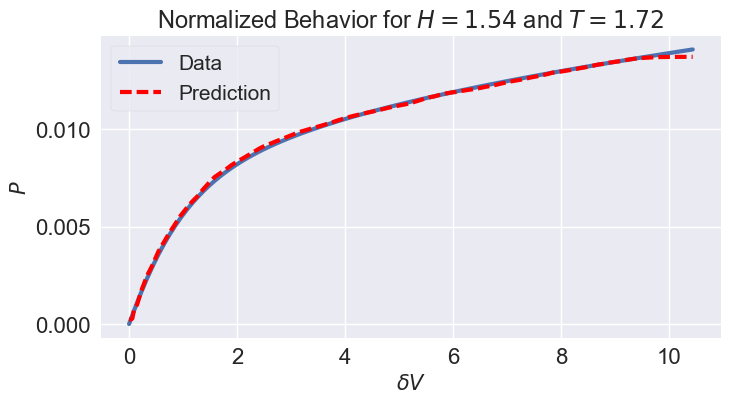

In [32]:
#Testing Plot with PV
#Filtering
H=77./50.;T=86./50.
rawData = obtainRows([H,T],dataPAll)
V=rawData[:,2]
P=rawData[:,-1]
V_predict=rawData[:,:-1]
P_predict=MLP.predict(V_predict)

plt.title(r'Normalized Behavior for $H={}$ and $T={}$'.format(H,T))
plt.xlabel(r'$\delta V$')
plt.ylabel(r'$P$')
plt.plot(V,P,label='Data',lw=3)
plt.plot(V,P_predict,'r--',label='Prediction',lw=3)
plt.legend()

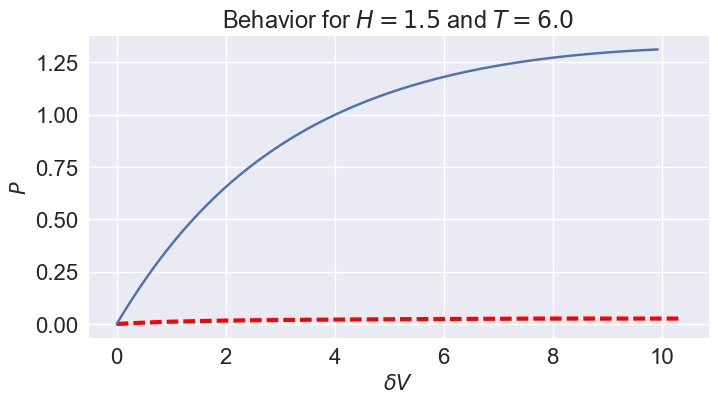

In [29]:
H=75./50.;T=300./50.
data2=np.loadtxt('pv-H75T300.txt', delimiter=' ')

V=linspace(0,13000/min(VPAll),100)
HAll=H+V*0
TAll=T+V*0
dataPredict=np.column_stack((HAll,TAll,V))
P_p=MLP.predict(dataPredict)
plt.title(r'Behavior for $H={}$ and $T={}$'.format(H,T))
plt.xlabel(r'$\delta V$')
plt.ylabel(r'$P$')
plt.plot(V,P_p,'r--',label='Prediction',lw=3)
plt.plot((data2[:,0]-min(data2[:,0]))/min(VPAll),data2[:,1])

# Using Gaussian Processes

In [13]:
from sklearn import gaussian_process

GPR=gaussian_process.GaussianProcessRegressor()#kernel=None, alpha=1e-10, optimizer='fmin_l_bfgs_b', 
    #n_restarts_optimizer=0, normalize_y=False, copy_X_train=True, random_state=None)

GPR.fit(XTrain,YTrain)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

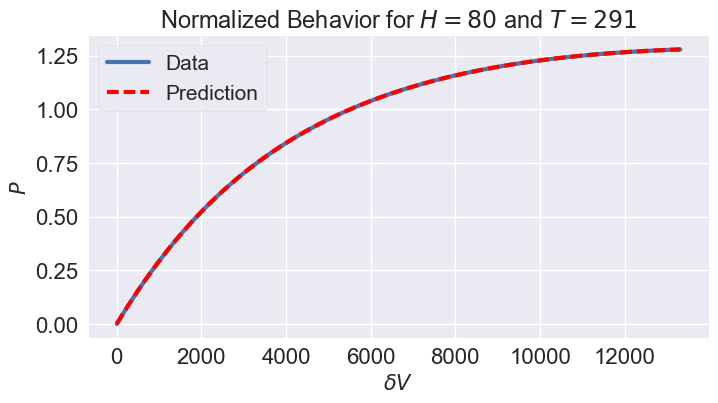

In [16]:
#Testing Plot with PV
#Filtering
H=80;T=291
rawData = obtainRows([H,T],dataPAll)
V=rawData[:,2]
P=rawData[:,-1]
V_predict=rawData[:,:-1]
P_predict=GPR.predict(V_predict)

plt.title(r'Normalized Behavior for $H=80$ and $T=291$')
plt.xlabel(r'$\delta V$')
plt.ylabel(r'$P$')
plt.plot(V,P,label='Data',lw=3)
plt.plot(V,P_predict,'r--',label='Prediction',lw=3)
plt.legend()

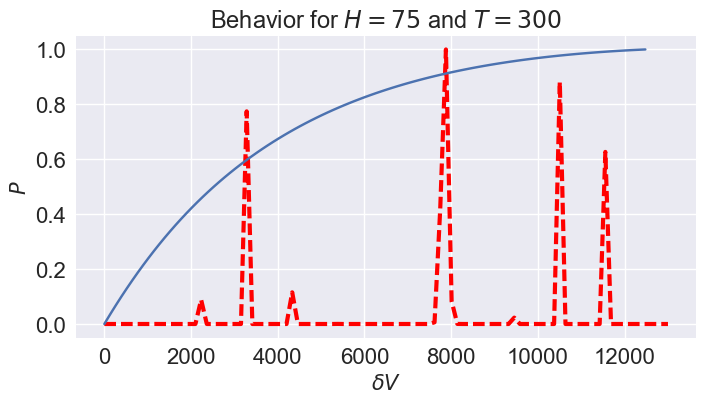

In [23]:
H=75;T=300
data2=np.loadtxt('pv-H75T300.txt', delimiter=' ')

V=linspace(0,13000,100)
HAll=H+V*0
TAll=T+V*0
dataPredict=np.column_stack((HAll,TAll,V))
P_p=GPR.predict(dataPredict)
plt.title(r'Behavior for $H=75$ and $T=300$')
plt.xlabel(r'$\delta V$')
plt.ylabel(r'$P$')
plt.plot(V,P_p/max(P_p),'r--',label='Prediction',lw=3)
plt.plot(data2[:,0],data2[:,1]/max(data2[:,1]))

# Using SVM's

In [26]:
from sklearn import svm

SVMR=svm.SVR(C=10, kernel='rbf')

SVMR.fit(XTrain,YTrain)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

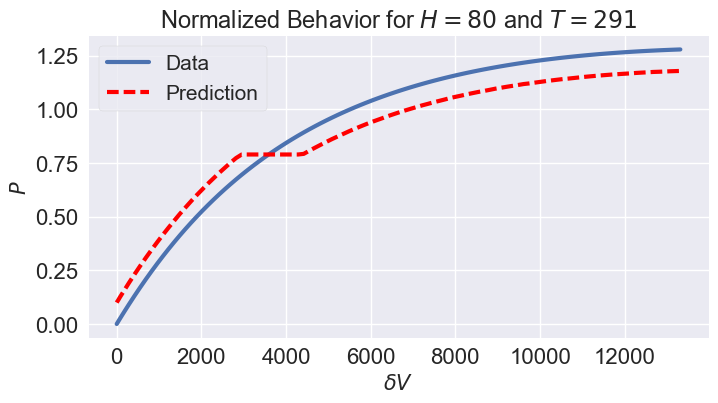

In [27]:
#Testing Plot with PV
#Filtering
H=80;T=291
rawData = obtainRows([H,T],dataPAll)
V=rawData[:,2]
P=rawData[:,-1]
V_predict=rawData[:,:-1]
P_predict=SVMR.predict(V_predict)

plt.title(r'Normalized Behavior for $H=80$ and $T=291$')
plt.xlabel(r'$\delta V$')
plt.ylabel(r'$P$')
plt.plot(V,P,label='Data',lw=3)
plt.plot(V,P_predict,'r--',label='Prediction',lw=3)
plt.legend()

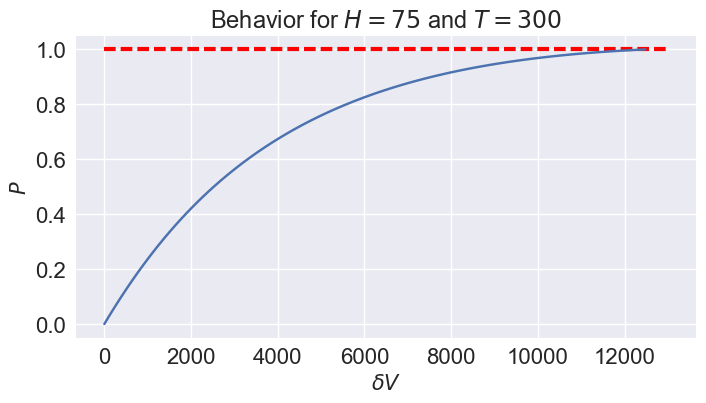

In [28]:
H=75;T=300
data2=np.loadtxt('pv-H75T300.txt', delimiter=' ')

V=linspace(0,13000,100)
HAll=H+V*0
TAll=T+V*0
dataPredict=np.column_stack((HAll,TAll,V))
P_p=SVMR.predict(dataPredict)
plt.title(r'Behavior for $H=75$ and $T=300$')
plt.xlabel(r'$\delta V$')
plt.ylabel(r'$P$')
plt.plot(V,P_p/max(P_p),'r--',label='Prediction',lw=3)
plt.plot(data2[:,0],data2[:,1]/max(data2[:,1]))

### Using tensor flow